⚓Kita akan belajar Clustering dengan dataset dinosaurus
goals nya adalah menentukan kelas nya masuk ke mana jenis dinosaurusnya

ini dengan CNN


**sTEP 1 : IMPORT LIBRARY**

In [1]:
import shutil
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from os import listdir

import torch
import torch.nn as nn
import cv2 as cv
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


#INI PAKE TORCH KARNA KITA PAKE DEEP LEARNING , kalo pake machine learning kan biasanya pake skealrn


c:\Users\jmjur\Documents\IPSD\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**STEP 2: GET DATA**

Ini ku dapet dari kaggle, jadi gausah download dan up, langsung manggil dari kaggle

In [ ]:
path = kagglehub.dataset_download("cmglonly/simple-dinosurus-dataset")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'simple-dinosurus-dataset' dataset.
Path to dataset files: /kaggle/input/simple-dinosurus-dataset


In [ ]:

src_path = "/kaggle/input/simple-dinosurus-dataset"
dst_path = "/content/dataset"

shutil.move(src_path, dst_path)
print("Dataset moved to:", dst_path)

OSError: [Errno 30] Read-only file system: '/kaggle/input/simple-dinosurus-dataset/triceratops'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**get data**


model kalo mau di masukkan harus di resizee dlu
namanya PRE TRAIN nanti jadi bisanya ukuran 224 x 224

tapi kalo configurasi model sendiri, bebas mau resize sendiri bebas mau ukurannya



In [ ]:
class getImageLabel(Dataset):
    def __init__(self, folder='/content/dataset/'):
        self.dataset = []

        # initiate the one hot encoding for class
        to_one_hot = np.eye(5)  # number of class
        for i, dino in enumerate(sorted(listdir(folder))):
            for image_name in listdir(folder + "/" + dino):
                # read image, resize image, and normalize image to 0-1 range
                image = cv.resize(cv.imread(folder + "/" + dino + "/" + image_name), (100, 100)) / 255
                # append feature image and one hot encoded label to public self.dataset
                self.dataset.append([image, to_one_hot[i]])

    def __getitem__(self, item):
        feature, label = self.dataset[item]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.dataset)

**MODELS**

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, input_dim=200, input_c=3, output=5, hidden_dim=128):
        super(SimpleCNN, self).__init__()

        self.convBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=input_c, out_channels=20, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3)),
        )

        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5)),
            nn.ReLU(), #INI FUNGSI AKTIVASINYA, BOLEH PAKE FUNGSI AKTIVASI YANG LAIN
            nn.MaxPool2d(kernel_size=(3, 3)),
        )
        self.fc = nn.Linear(in_features=50 * 9 * 9, out_features=output)
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.convBlock1(x)
        x = self.convBlock2(x)

        x = self.fc(torch.flatten(x, 1))
        x = self.Softmax(x)

        return x

**TRAIN**

In [ ]:
def train():
    BATCH_SIZE = 32 # NAH INI MAKIN BATCH SIZE GEDE SEMAKIN CEPAT EPOCH NYA
    EPOCH = 10
    LEARNING_RATE = 0.001 #EFEKTIVITAS , BISANYA DEFAULT NYA KITA MULAI DI 0.001 , atau kalo grafiknya agak aneh bisa di turunin atau dinaikin.

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    train_loader = DataLoader(getImageLabel(folder="/content/dataset"), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(getImageLabel(folder="/content/dataset"), batch_size=BATCH_SIZE, shuffle=False)

    model = SimpleCNN(input_dim=200, input_c=3, output=5, hidden_dim=128)
    model = model.to(device)

    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    loss_function = nn.CrossEntropyLoss()

    loss_train_all, loss_test_all = [], []
    for epoch in range(EPOCH):
        train_loss = 0
        test_loss = 0
        model.train()
        for batch, (src, trg) in enumerate(train_loader):
            src = src.permute(0, 3, 1, 2).to(device)
            trg = trg.to(device)

            pred = model(src)
            loss = loss_function(pred, trg)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #
        model.eval()
        for batch, (src, trg) in enumerate(test_loader):
            src = src.permute(0, 3, 1, 2).to(device)
            trg = trg.to(device)

            pred = model(src)
            loss = loss_function(pred, trg)
            test_loss += loss.item()

        loss_train_all.append(train_loss / len(train_loader))
        loss_test_all.append(test_loss / len(test_loader))
        print("epoch = ", epoch + 1, "train loss = ", train_loss / len(train_loader), ", test loss = ",
              test_loss / len(test_loader))

        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss / len(train_loader),
            }, "/content/SimpleCNN_" + str(epoch + 1) + ".pt")

    plt.plot(range(EPOCH), loss_train_all, color="#931a00", label='Training')
    plt.plot(range(EPOCH), loss_test_all, color="#3399e6", label='Testing')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig("/content/training.png")



Using device: cuda
epoch =  1 train loss =  1.6074268477303642 , test loss =  1.5842215503965105
epoch =  2 train loss =  1.568273663520813 , test loss =  1.5052399294716972
epoch =  3 train loss =  1.4624980347497123 , test loss =  1.333085639136178
epoch =  4 train loss =  1.2316180637904577 , test loss =  1.1531096015657698
epoch =  5 train loss =  1.1058096289634705 , test loss =  1.160581009728568
epoch =  6 train loss =  1.1091811912400382 , test loss =  1.1417827776500158
epoch =  7 train loss =  1.094433103288923 , test loss =  1.1330266850335258
epoch =  8 train loss =  1.0770702702658517 , test loss =  1.0487706661224365
epoch =  9 train loss =  1.0332500083105904 , test loss =  1.0221030116081238
epoch =  10 train loss =  1.0479611839566911 , test loss =  1.0160921726908003


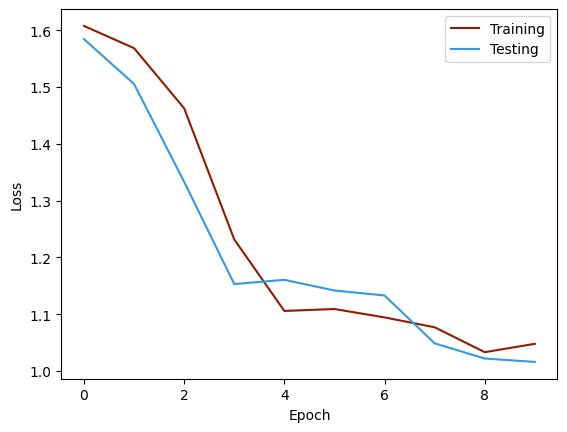

In [ ]:
train()

**TESTING**

In [ ]:
def test():
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    test_loader = DataLoader(getImageLabel(folder="/content/dataset/"),
                             batch_size=BATCH_SIZE, shuffle=True)

    model = SimpleCNN(input_dim=200, input_c=3, output=5, hidden_dim=128)
    model = model.to(device)

    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    checkpoint = torch.load("SimpleCNN_10.pt", map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    prediction, ground_truth = [], []

    with torch.no_grad():
        model.eval()
        for batch, (src, trg) in enumerate(test_loader):
            src = src.permute(0, 3, 1, 2).to(device)
            trg = trg.to(device)

            pred = model(src)
            prediction.extend(torch.argmax(pred, dim=1).cpu().numpy())
            ground_truth.extend(torch.argmax(trg, dim=1).cpu().numpy())

    classes = ('ankylosaurus', 'brontosaurus', 'pterodactyl', 'trex', 'triceratops')

    cf_matrix = confusion_matrix(ground_truth, prediction)
    print(cf_matrix)

    df_cm = pd.DataFrame(cf_matrix,
                        index=[i for i in classes],
                        columns=[i for i in classes])

    plt.figure(figsize=(12, 7))
    sn.heatmap(df_cm, annot=True, fmt='d')
    plt.savefig("confusion_matrix.png")

    print("accuracy score =", accuracy_score(ground_truth, prediction))
    print("precision score =", precision_score(ground_truth, prediction, average='weighted'))
    print("recall score =", recall_score(ground_truth, prediction, average='weighted'))
    print("f1 score =", f1_score(ground_truth, prediction, average='weighted'))


        #fungsi aptimazer pake adam, pake yg lain juga boleh
        #optimazer itu mengoptimalkan agar los fung nya rendah

Using device: cuda
[[31  0  0  0  9]
 [ 0 37  2  0  1]
 [ 1  0 39  0  0]
 [ 0  0  0 38  2]
 [ 1  0  0  0 39]]
accuracy score = 0.92
precision score = 0.9310638667884006
recall score = 0.92
f1 score = 0.9209637647993811


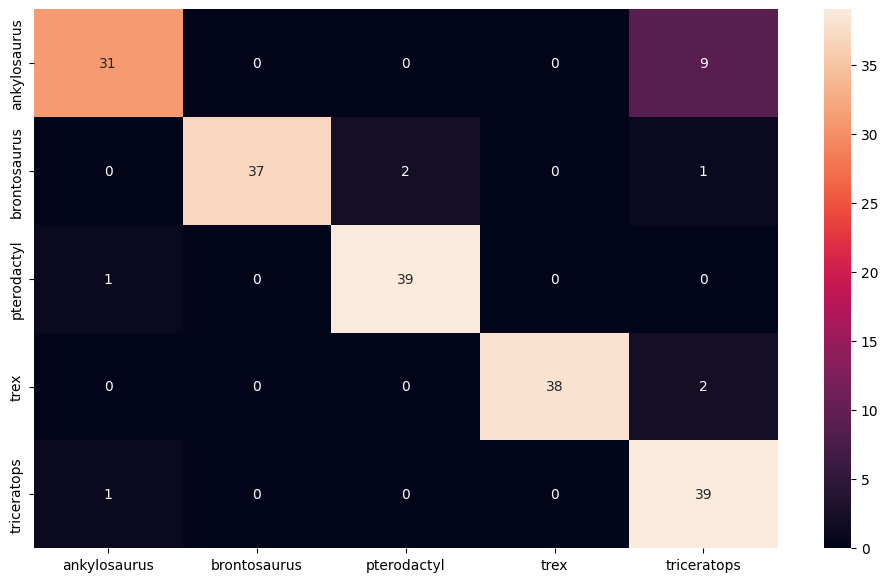

In [ ]:
test()

#ini agar accurasy bagus ada bbrp faktor : preprocessing nya, cari model yg cocok yg mana, baru kita check
#baru kita check regulasation(cari parameter yg sesuai misalkayak optimazaer yg kayak adam atau apa )